# Node/Edge Removal Analysis Notebook

This notebook mirrors the shell helpers under `analysis/`:

1. Read every `EBE_*.dat` file
2. Compute the same column-wise statistics as `statistical_analysis`
3. Extract finite-size-scaling (FSS) curves
4. Fit the power law `y = A N^\alpha` and plot

Adjust `DATA_DIR` below if your files live elsewhere.

In [38]:
from __future__ import annotations

import math
import re
from pathlib import Path
from typing import Dict, Iterable, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import analysis_utils as au

plt.style.use('seaborn-v0_8-colorblind')


## Paths and constants

In [39]:
ROOT_DIR = Path(__file__).resolve().parent if '__file__' in globals() else Path.cwd()
CONFIGS = {
    'node': {
        'folder': 'node_percolation',
        'file_prefix': 'NR_EBE_',
        'ci_radius': 0,
    },
    'link': {
        'folder': 'link_percolation',
        'file_prefix': 'LR_EBE_',
        'ci_radius': 0,
    },
}

DATASET = 'node'  # choose 'node' or 'link'
cfg = CONFIGS[DATASET]
DATA_DIR = ROOT_DIR / cfg['folder']
FILE_PREFIX = cfg['file_prefix']
CI_RADIUS_FILTER = cfg['ci_radius']
pat = f"{FILE_PREFIX}*.dat"
stats_name = f"stats_{FILE_PREFIX}*.dat"
OUTPUT_DIR = DATA_DIR
DATA_DIR.mkdir(parents=True, exist_ok=True)


## Column metadata

In [40]:
COLUMN_MAP = au.COLUMN_MAP
COLUMN_LOOKUP = au.COLUMN_LOOKUP


## IO helpers

## FSS extraction + power law fit

In [41]:
au.compute_effective_exponents.__doc__


'Sliding-window effective exponents via weighted log-log fits.'

## Example workflow

In [42]:
summary = au.process_all_ebe(DATA_DIR, OUTPUT_DIR, pattern=pat, ci_radius_filter=CI_RADIUS_FILTER)
summary[['file', 'ci_radius', 'M_graphs', 'runs', 'N']]


,file,ci_radius,M_graphs,runs,N
0,NR_EBE_NR_ER_N1048576_c4.00_ci_L0_Mg10000_Mr1.dat,0,10000,10000,1048576
1,NR_EBE_NR_ER_N131072_c4.00_ci_L0_Mg10000_Mr1.dat,0,10000,10000,131072
2,NR_EBE_NR_ER_N16384_c4.00_ci_L0_Mg10000_Mr1.dat,0,10000,10000,16384
3,NR_EBE_NR_ER_N262144_c4.00_ci_L0_Mg10000_Mr1.dat,0,10000,10000,262144
4,NR_EBE_NR_ER_N32768_c4.00_ci_L0_Mg10000_Mr1.dat,0,10000,10000,32768
5,NR_EBE_NR_ER_N4096_c4.00_ci_L0_Mg10000_Mr1.dat,0,10000,10000,4096
6,NR_EBE_NR_ER_N524288_c4.00_ci_L0_Mg10000_Mr1.dat,0,10000,10000,524288
7,NR_EBE_NR_ER_N65536_c4.00_ci_L0_Mg10000_Mr1.dat,0,10000,10000,65536
8,NR_EBE_NR_ER_N8192_c4.00_ci_L0_Mg10000_Mr1.dat,0,10000,10000,8192


In [43]:
stats_files = [
    path
    for path in sorted(OUTPUT_DIR.glob(stats_name))
    if (CI_RADIUS_FILTER is None or au.extract_ci_radius(path.name) == CI_RADIUS_FILTER)
]
stats_files[:3], len(stats_files)


([PosixPath('/nfs/nfs2/home/hanlsun/global_removal/node_percolation/stats_NR_EBE_NR_ER_N1048576_c4.00_ci_L0_Mg10000_Mr1.dat'),
  PosixPath('/nfs/nfs2/home/hanlsun/global_removal/node_percolation/stats_NR_EBE_NR_ER_N131072_c4.00_ci_L0_Mg10000_Mr1.dat'),
  PosixPath('/nfs/nfs2/home/hanlsun/global_removal/node_percolation/stats_NR_EBE_NR_ER_N16384_c4.00_ci_L0_Mg10000_Mr1.dat')],
 9)

In [44]:
OBSERVABLES = [
    ("P(p+)", 4),
    ("P(q0)", 14),
]

fss_results = {}
fit_results = {}
for label, row in OBSERVABLES:
    fss = au.extract_fss(stats_files, row=row, value_kind='mean')
    fss_results[label] = fss
    fit_results[label] = au.weighted_log_fit(fss) if not fss.empty else None


/nfs/nfs2/home/hanlsun/global_removal/analysis_utils.py:237: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(row_data["mean"])
/nfs/nfs2/home/hanlsun/global_removal/analysis_utils.py:238: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  error = float(row_data["err_mean"])


In [45]:
EFFECTIVE_WINDOW = 3  # points per window for effective exponents


In [46]:
fss_results['P(p+)'], fit_results['P(p+)']


(         N       value       error  \
 0     4096    688.3308    2.468814   
 1     8192   1126.0668    4.112996   
 2    16384   1824.3419    6.824351   
 3    32768   2967.1404   11.344072   
 4    65536   4808.6977   18.662370   
 5   131072   7697.1248   29.977125   
 6   262144  12370.1854   48.881333   
 7   524288  19822.8789   78.912241   
 8  1048576  31824.2830  128.357493   
 
                                               source  
 0  stats_NR_EBE_NR_ER_N4096_c4.00_ci_L0_Mg10000_M...  
 1  stats_NR_EBE_NR_ER_N8192_c4.00_ci_L0_Mg10000_M...  
 2  stats_NR_EBE_NR_ER_N16384_c4.00_ci_L0_Mg10000_...  
 3  stats_NR_EBE_NR_ER_N32768_c4.00_ci_L0_Mg10000_...  
 4  stats_NR_EBE_NR_ER_N65536_c4.00_ci_L0_Mg10000_...  
 5  stats_NR_EBE_NR_ER_N131072_c4.00_ci_L0_Mg10000...  
 6  stats_NR_EBE_NR_ER_N262144_c4.00_ci_L0_Mg10000...  
 7  stats_NR_EBE_NR_ER_N524288_c4.00_ci_L0_Mg10000...  
 8  stats_NR_EBE_NR_ER_N1048576_c4.00_ci_L0_Mg1000...  ,
 {'A': 2.2291656793878283,
  'A_err': 0.0175849

In [47]:
fss_results['P(q0)'], fit_results['P(q0)']


(         N       value      error  \
 0     4096    414.8798   2.095207   
 1     8192    672.8013   3.385537   
 2    16384   1080.7449   5.515750   
 3    32768   1742.6690   8.986839   
 4    65536   2801.3264  14.430453   
 5   131072   4511.5781  23.566441   
 6   262144   7221.2439  37.983734   
 7   524288  11367.8266  59.524573   
 8  1048576  18399.1784  95.900049   
 
                                               source  
 0  stats_NR_EBE_NR_ER_N4096_c4.00_ci_L0_Mg10000_M...  
 1  stats_NR_EBE_NR_ER_N8192_c4.00_ci_L0_Mg10000_M...  
 2  stats_NR_EBE_NR_ER_N16384_c4.00_ci_L0_Mg10000_...  
 3  stats_NR_EBE_NR_ER_N32768_c4.00_ci_L0_Mg10000_...  
 4  stats_NR_EBE_NR_ER_N65536_c4.00_ci_L0_Mg10000_...  
 5  stats_NR_EBE_NR_ER_N131072_c4.00_ci_L0_Mg10000...  
 6  stats_NR_EBE_NR_ER_N262144_c4.00_ci_L0_Mg10000...  
 7  stats_NR_EBE_NR_ER_N524288_c4.00_ci_L0_Mg10000...  
 8  stats_NR_EBE_NR_ER_N1048576_c4.00_ci_L0_Mg1000...  ,
 {'A': 1.429881191999632,
  'A_err': 0.015313439731511851

## Giant component vs removed fraction

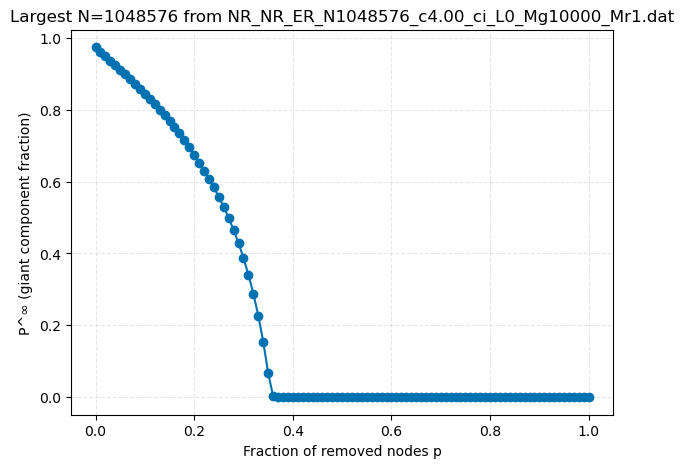

In [48]:
au.plot_giant_component_vs_p(DATA_DIR, FILE_PREFIX, CI_RADIUS_FILTER)


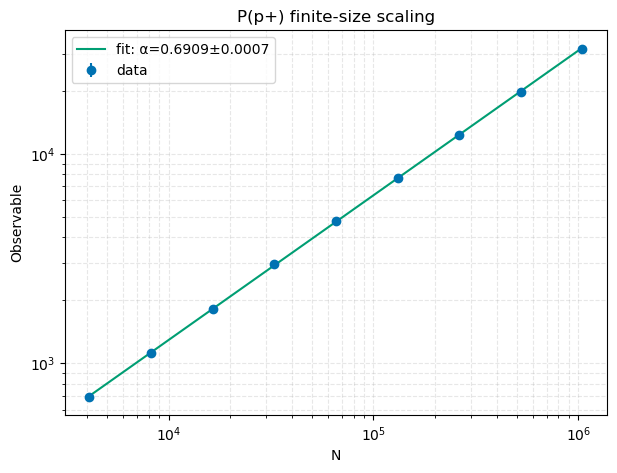

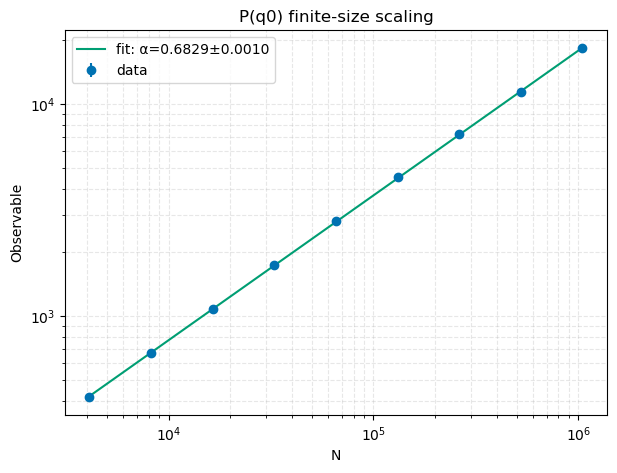

In [49]:
for label, _ in OBSERVABLES:
    fss = fss_results[label]
    fit = fit_results[label]
    if fss.empty or fit is None:
        print(f'No data for {label}')
        continue
    au.plot_fss_with_fit(fss, fit, title=f"{label} finite-size scaling")


/nfs/nfs2/home/hanlsun/global_removal/analysis_utils.py:237: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(row_data["mean"])
/nfs/nfs2/home/hanlsun/global_removal/analysis_utils.py:238: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  error = float(row_data["err_mean"])


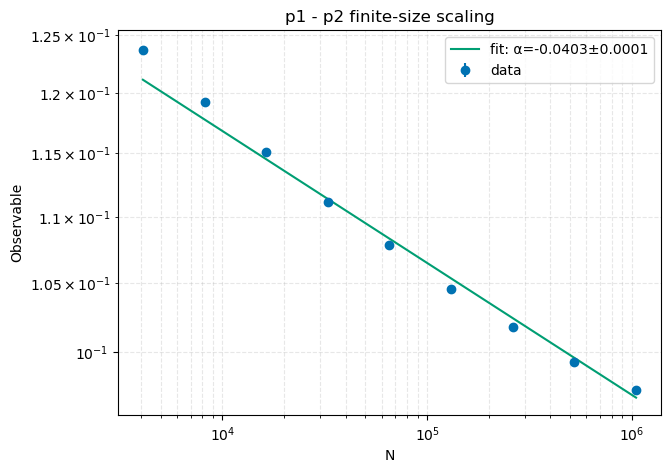

In [50]:
fss_gap = au.extract_p1_minus_p2(stats_files, value_kind='mean')
fit_gap = au.weighted_log_fit(fss_gap)
au.plot_fss_with_fit(fss_gap, fit_gap, title='p1 - p2 finite-size scaling')


In [51]:
effective_results = {}
for label, _ in OBSERVABLES:
    fss = fss_results[label]
    if fss.empty:
        effective_results[label] = pd.DataFrame()
    else:
        effective_results[label] = au.compute_effective_exponents(fss, window=EFFECTIVE_WINDOW)


In [52]:
effective_results['P(p+)']


,N_left,N_right,N_geom,exponent,exponent_err
0,4096.0,16384.0,8192.0,0.703200,0.003737
1,8192.0,32768.0,16384.0,0.698848,0.003813
2,16384.0,65536.0,32768.0,0.699166,0.003887
3,32768.0,131072.0,65536.0,0.687678,0.003937
4,65536.0,262144.0,131072.0,0.681557,0.003995
5,131072.0,524288.0,262144.0,0.682403,0.004017
6,262144.0,1048576.0,524288.0,0.681621,0.004073


In [53]:
effective_results['P(q0)']


,N_left,N_right,N_geom,exponent,exponent_err
0,4096.0,16384.0,8192.0,0.690655,0.005179
1,8192.0,32768.0,16384.0,0.686501,0.005197
2,16384.0,65536.0,32768.0,0.687049,0.005231
3,32768.0,131072.0,65536.0,0.686161,0.005295
4,65536.0,262144.0,131072.0,0.683099,0.005310
5,131072.0,524288.0,262144.0,0.666636,0.005335
6,262144.0,1048576.0,524288.0,0.674722,0.005342


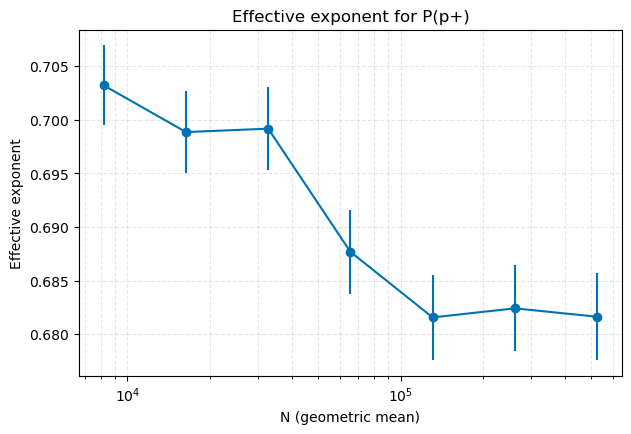

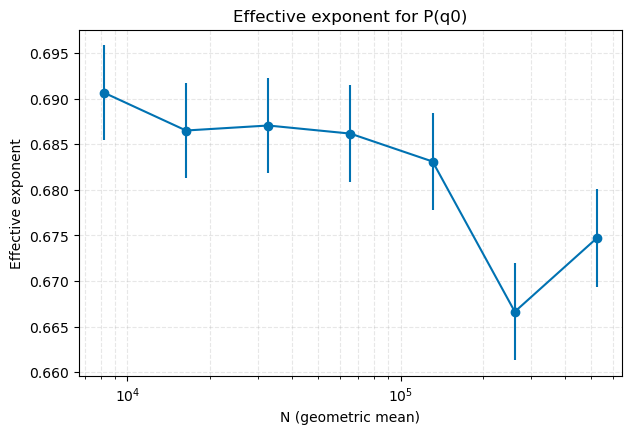

In [54]:
for label, _ in OBSERVABLES:
    eff = effective_results[label]
    if eff.empty:
        print(f'No effective exponents for {label}')
        continue
    au.plot_effective_exponent(eff, title=f"Effective exponent for {label}")


## Jump-height scaling

Plot the normalized jump height dP(p+) versus system size and fit a power law in log-log space.

/nfs/nfs2/home/hanlsun/global_removal/analysis_utils.py:237: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(row_data["mean"])
/nfs/nfs2/home/hanlsun/global_removal/analysis_utils.py:238: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  error = float(row_data["err_mean"])


         N     value     error
0     4096  0.050395  0.000197
1     8192  0.040369  0.000158
2    16384  0.031877  0.000125
3    32768  0.025602  0.000103
4    65536  0.020466  0.000083
5   131072  0.016424  0.000067
6   262144  0.013100  0.000054
7   524288  0.010347  0.000043
8  1048576  0.008329  0.000035
Jump-height fit: {'A': 0.7505485088057839, 'A_err': 0.00627528010427825, 'alpha': np.float64(-0.32479067070584966), 'alpha_err': 0.0007494145451220592, 'chi2_red': 1.3927531334985221, 'fit_used_abs': False, 'fit_value_sign': 1.0}


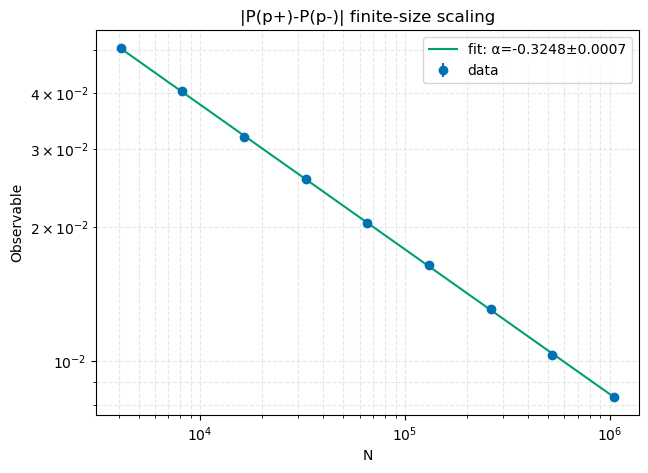

In [55]:
jump_fss = au.extract_fss(stats_files, row=3, value_kind='mean')
if jump_fss.empty:
    print('No jump-height data found; regenerate stats with updated binaries.')
else:
    jump_fit = au.weighted_log_fit(jump_fss)
    print(jump_fss[['N', 'value', 'error']])
    print('Jump-height fit:', jump_fit)
    au.plot_fss_with_fit(jump_fss, jump_fit, title='|P(p+)-P(p-)| finite-size scaling')
